In [85]:
import time
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:

# PREPROCESSING
def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler





In [ ]:

def train_pca(target_variances, X_train, X_test):
    pca_l = []
    for variance in target_variances:
        pca = PCA(n_components = variance)
        pca.fit(X_train)
        pca_l.append(pca)
    X_reduced = []
    for pca in pca_l:
        X_reduced.append((pca.transform(X_train),pca.transform(X_test)))
    return X_reduced, pca_l
    



(2614,)


In [ ]:

def evaluate(X_reduced, y_train, y_test):
    accs = []
    times = []
    for X_train_reduced, X_test_reduced in X_reduced:
        svm = SVC(C = 10, degree= 3, gamma= "scale", kernel= "poly")

        start_train = time.time()
        svm.fit(X_train_reduced, y_train)
        end_train = time.time()

        start_pred = time.time()
        y_pred = svm.predict(X_test_reduced)
        end_pred = time.time()

        train_time = end_train - start_train
        pred_time = end_pred - start_pred
        acc = accuracy_score(y_test, y_pred)

        times.append((train_time, pred_time))
        accs.append(acc)

    best_score = 0
    best_index = None
    for i in range(len(accs)):
        if accs[i] > best_score:
            best_score = accs[i]
            best_index = i
    return times, accs, best_score, best_index

   Varianza  n_components  Train Time (s)  Predict Time (s)  Accuracy
0      0.95           222        7.761231          1.808109  0.790742
1      0.90           157        5.124678          1.334543  0.789212
2      0.85           117        4.871989          0.989955  0.795333
3      0.80            89        3.269277          0.700825  0.796098
4      0.75            69        2.695611          0.705522  0.801454
5      0.70            53        2.123503          0.676597  0.794185
6      0.65            41        1.677567          0.546015  0.783091


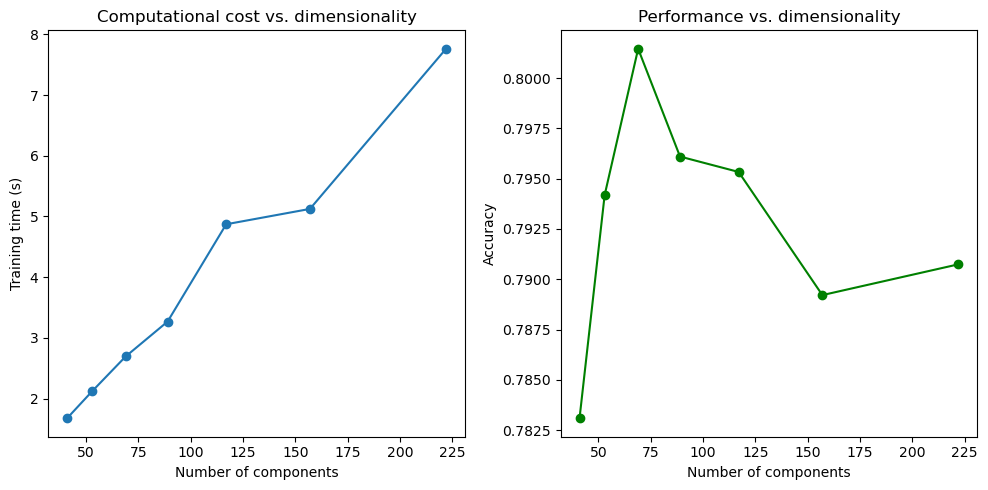

In [ ]:
def visualize_results(variances, pca_l, times, accs):
    results = []
    for i in range(len(variances)):
        results.append((variances[i], pca_l[i].n_components_, times[i][0], times[i][1], accs[i]))
    df_resultados = pd.DataFrame(results, columns=["Varianza", "n_components", "Train Time (s)", "Predict Time (s)", "Accuracy"])
    print(df_resultados)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(df_resultados["n_components"], df_resultados["Train Time (s)"], marker='o')
    plt.xlabel("Number of components")
    plt.ylabel("Training time (s)")
    plt.title("Computational cost vs. dimensionality")

    plt.subplot(1,2,2)
    plt.plot(df_resultados["n_components"], df_resultados["Accuracy"], marker='o', color='green')
    plt.xlabel("Number of components")
    plt.ylabel("Accuracy")
    plt.title("Performance vs. dimensionality")

    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == "__main__":
    dataset = np.load("dataset.npz")

    X, y = dataset["X"], dataset["y"]


    X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.4, random_state=42, stratify=y
        )
    X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
            )
    
    # preprocess
    X_train_scaled, X_val_scaled, scaler = preprocess_data(X_train, X_val)
    X_test_scaled = scaler.transform(X_test)

    target_variances = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65]

    X_reduced, pca_l = train_pca(target_variances, X_train_scaled, X_test_scaled)

    times, accs, best_score, best_index = evaluate(X_reduced, y_train, y_test)

    visualize_results(target_variances, pca_l, times, accs)
